In [1]:
print("This is an amazing project by Ludvig Kratzert, Jonathan Collaud and Katharina Pescoller.")

This is an amazing project by Ludvig Kratzert, Jonathan Collaud and Katharina Pescoller.


# Loading the model, test function

In [1]:
import argparse
import os
import time
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.utils
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from matplotlib import pyplot as plt
from matplotlib import image

alexnet = models.alexnet(pretrained=True)

In [2]:
# Data loading code
traindir = 'tiny-imagenet-200/train'
valdir = 'tiny-imagenet-200/val'
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True)



/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/site-packages/torchvision/transforms/transforms.py:219: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [3]:
criterion = nn.CrossEntropyLoss().cuda()

def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    top5 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        #target = target.cuda(async=True)
        with torch.no_grad():
            input_var = torch.autograd.Variable(input)
            target_var = torch.autograd.Variable(target)

        # compute output
        output = model(input_var)
        loss = criterion(output, target_var)

        # measure accuracy and record loss
        prec1, prec5 = accuracy(output.data, target, topk=(1, 5))
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))
        top5.update(prec5.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 10 == 0:
            print('Test: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})\t'
                  'Prec@5 {top5.val:.3f} ({top5.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,
                   top1=top1, top5=top5))

    print(' * Prec@1 {top1.avg:.3f} Prec@5 {top5.avg:.3f}'
          .format(top1=top1, top5=top5))

    return top1.avg

In [4]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res


In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


In [6]:
validate(val_loader, alexnet, criterion)

Test: [0/40]	Time 9.780 (9.780)	Loss 10.8183 (10.8183)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)


Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
  File "/Users/Ludvig/.pyenv/versions/3.7.6/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/Ludvig/.pyenv/versi

KeyboardInterrupt: 

# Random pixels attack

In [73]:
class RandomPixelsAttack(object):
    """Makes n random pixels red"""

    def __call__(self, sample):
        #image, landmarks = sample['image'], sample['landmarks']
        
        n = 5
        
        #img = image.imread(sample)
        img = sample
        
        for i in range(n):
            x = random.randrange(224)
            y = random.randrange(224)
            img[0, x, y] = 255

        return img        
            #return {'image': torch.from_numpy(image),
                #'landmarks': torch.from_numpy(landmarks)}

In [74]:
 # We override val_loader with out attack added in as a transform
 val_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(valdir, transforms.Compose([
            transforms.Scale(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            RandomPixelsAttack(),
            normalize,
        ])),
        batch_size=256, shuffle=False,
        num_workers=4, pin_memory=True)

start


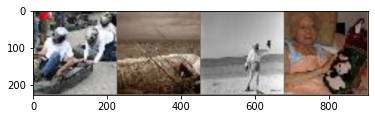

In [75]:
import numpy as np

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

print("start")

# Get a batch of training data
# inputs contains 4 images because batch_size=4 for the dataloaders
inputs, classes = next(iter(val_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:4])

imshow(out)


In [76]:
validate(val_loader, alexnet, criterion)

Test: [0/40]	Time 15.800 (15.800)	Loss 279.6014 (279.6014)	Prec@1 0.000 (0.000)	Prec@5 0.000 (0.000)


KeyboardInterrupt: 